# Project by Andrea Sanchietti

This is the second homework for the machine learning course.

It requires to design a model for classification of images from a dataset made of at least 10 diffrerent classes.

The dataset that i decided to use is the EuroSAT Dataset: a collection of satellitar images based on Sentinel-2 satellite images covering 13 spectral bands and consisting out of 10 classes with in total 27,000 labeled and geo-referenced images.

The first thing to do is to import libraries:

In [43]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import Callback
from scikitplot.metrics import plot_confusion_matrix, plot_roc
import config
from sklearn.metrics import ConfusionMatrixDisplay

if True:
    import wandb
    from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
    wandb.init(project="ML-final-project", entity="andr3us")

The next step is reading the dataset:

In [44]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  config.data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(config.img_height, config.img_width),
  batch_size=config.batch_size)

Found 27000 files belonging to 10 classes.
Using 21600 files for training.


In [45]:
val_ds: tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
  config.data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(config.img_height, config.img_width),
  batch_size=config.batch_size)

Found 27000 files belonging to 10 classes.
Using 5400 files for validation.


In [46]:
class_names = train_ds.class_names
print(class_names)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


2022-12-27 13:33:00.161645: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [21600]
	 [[{{node Placeholder/_0}}]]
2022-12-27 13:33:00.161825: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [21600]
	 [[{{node Placeholder/_4}}]]


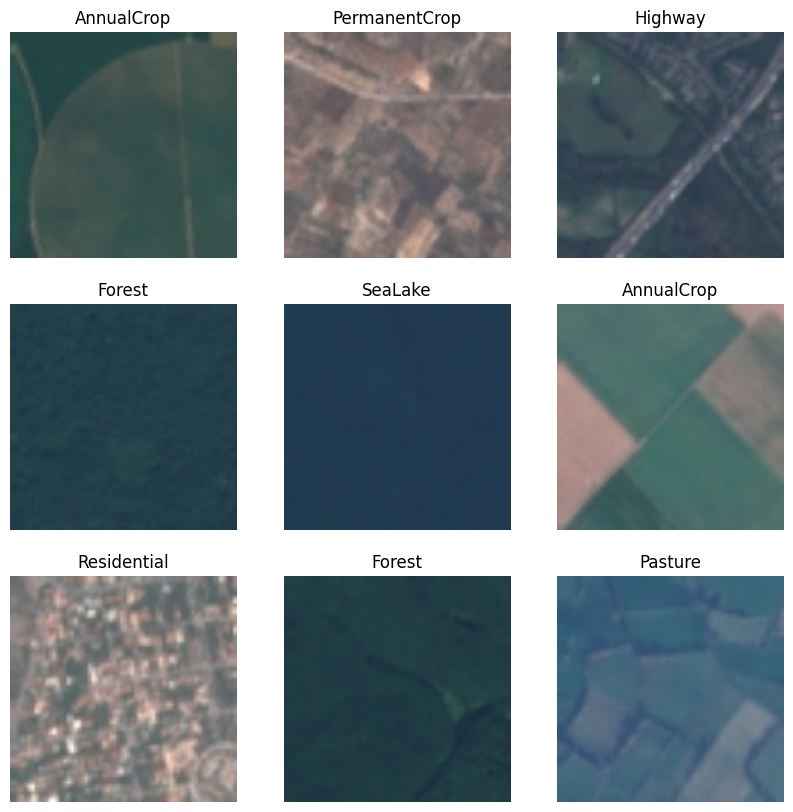

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [48]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


2022-12-27 13:33:00.883615: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [21600]
	 [[{{node Placeholder/_4}}]]
2022-12-27 13:33:00.884107: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [21600]
	 [[{{node Placeholder/_0}}]]


In [49]:
# Normalizing the data

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), tf.one_hot(y, 10)))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), tf.one_hot(y, 10)))

In [50]:

def resblock(x, filters, kernelsize):
    fx = tf.keras.layers.Conv2D(filters, kernelsize, activation='relu', padding='same')(x)
    fx = tf.keras.layers.BatchNormalization()(fx)
    fx = tf.keras.layers.Conv2D(filters, kernelsize, padding='same')(fx)
    out = tf.keras.layers.Add()([x,fx])
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.BatchNormalization()(out)
    return out

def convblock2d(x, filters, kernelsize: int, num_convs: int, activation="relu", padding="same"):
    if num_convs <= 0:
        return x
    out = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernelsize, padding=padding)(x)
    out = tf.keras.layers.ReLU()(out)
    for i in range(num_convs - 1):
        out = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernelsize, activation="relu", padding=padding)(out)
        out = tf.keras.layers.ReLU()(out)
    return out


inputs = tf.keras.Input(shape=(180, 180, 3))
hidden_layer = convblock2d(inputs, 64, 3, 2)
hidden_layer = resblock(hidden_layer, 64, 3)
hidden_layer = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", strides=2)(hidden_layer)
hidden_layer = convblock2d(hidden_layer, 126, 3, 2)
hidden_layer = resblock(hidden_layer, 126, 3)
hidden_layer = tf.keras.layers.Conv2D(filters=126, kernel_size=3, padding="same", activation="relu", strides=2)(hidden_layer)
hidden_layer = convblock2d(hidden_layer, 256, 3, 3)
hidden_layer = resblock(hidden_layer, 256, 3)
hidden_layer = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu", strides=2)(hidden_layer)
hidden_layer = convblock2d(hidden_layer, 512, 3, 3)
hidden_layer = resblock(hidden_layer, 512, 3)
hidden_layer = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu", strides=2)(hidden_layer)
hidden_layer = convblock2d(hidden_layer, 1024, 3, 3)
hidden_layer = resblock(hidden_layer, 1024, 3)
hidden_layer = tf.keras.layers.Flatten()(hidden_layer)
output_layer = tf.keras.layers.Dense(10, activation="sigmoid")(hidden_layer)

model = keras.Model(inputs=inputs, outputs=output_layer, name="my-model")
model.summary()


Model: "my-model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 180, 180, 12  3584        ['input_2[0][0]']                
                                8)                                                                
                                                                                                  
 re_lu_18 (ReLU)                (None, 180, 180, 12  0           ['conv2d_27[0][0]']              
                                8)                                                         

In [51]:
tf.config.list_physical_devices('GPU') # True/False

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [52]:
class PerformanceVisualizationCallback(Callback):
    def __init__(self, model, validation_data, image_dir):
        super().__init__()
        self.model = model
        self.validation_data = validation_data

        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.asarray(self.model.predict(self.validation_data[0]))
        y_true = self.validation_data[1]
        y_pred_class = np.argmax(y_pred, axis=1)

        # plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(16,12))
        plot_confusion_matrix(y_true, y_pred_class, ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))

       # plot and save roc curve
        fig, ax = plt.subplots(figsize=(16,12))
        plot_roc(y_true, y_pred, ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'roc_curve_epoch_{epoch}'))

In [53]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=5e-4),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=[tf.keras.metrics.BinaryCrossentropy(), tf.keras.metrics.CategoricalAccuracy()])

images, labels = tuple(zip(*val_ds))

performance_cbk = PerformanceVisualizationCallback(
                      model=model,
                      validation_data=(images, labels),
                      image_dir='performance_vizualizations')


history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=150,
  batch_size=config.batch_size,
  callbacks=[WandbMetricsLogger(log_freq="batch"),
  WandbModelCheckpoint("models", save_best_only=True)]
)


2022-12-27 13:33:01.414739: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5400]
	 [[{{node Placeholder/_4}}]]
2022-12-27 13:33:01.414965: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5400]
	 [[{{node Placeholder/_0}}]]


Epoch 1/40


2022-12-27 13:33:01.765947: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [21600]
	 [[{{node Placeholder/_0}}]]
2022-12-27 13:33:01.766223: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [21600]
	 [[{{node Placeholder/_4}}]]


  6/675 [..............................] - ETA: 2:08 - loss: 0.9059 - binary_crossentropy: 0.9059 - categorical_accuracy: 0.0781WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0642s vs `on_train_batch_end` time: 0.1061s). Check your callbacks.


675/675 [==============================] - ETA: 0s - loss: 0.7999 - binary_crossentropy: 0.7999 - categorical_accuracy: 0.1036

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


675/675 [==============================] - 150s 219ms/step - loss: 0.7999 - binary_crossentropy: 0.7999 - categorical_accuracy: 0.1036 - val_loss: 0.6256 - val_binary_crossentropy: 0.6256 - val_categorical_accuracy: 0.1148
Epoch 2/40
675/675 [==============================] - ETA: 0s - loss: 0.5918 - binary_crossentropy: 0.5918 - categorical_accuracy: 0.1541

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


675/675 [==============================] - 143s 211ms/step - loss: 0.5918 - binary_crossentropy: 0.5918 - categorical_accuracy: 0.1541 - val_loss: 0.5182 - val_binary_crossentropy: 0.5182 - val_categorical_accuracy: 0.1441
Epoch 3/40
675/675 [==============================] - ETA: 0s - loss: 0.4308 - binary_crossentropy: 0.4308 - categorical_accuracy: 0.2209

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


675/675 [==============================] - 145s 214ms/step - loss: 0.4308 - binary_crossentropy: 0.4308 - categorical_accuracy: 0.2209 - val_loss: 0.3938 - val_binary_crossentropy: 0.3938 - val_categorical_accuracy: 0.2248
Epoch 4/40
675/675 [==============================] - ETA: 0s - loss: 0.3601 - binary_crossentropy: 0.3601 - categorical_accuracy: 0.2536

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


675/675 [==============================] - 140s 208ms/step - loss: 0.3601 - binary_crossentropy: 0.3601 - categorical_accuracy: 0.2536 - val_loss: 0.3368 - val_binary_crossentropy: 0.3368 - val_categorical_accuracy: 0.2693
Epoch 5/40
675/675 [==============================] - ETA: 0s - loss: 0.3275 - binary_crossentropy: 0.3275 - categorical_accuracy: 0.2694

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


675/675 [==============================] - 145s 215ms/step - loss: 0.3275 - binary_crossentropy: 0.3275 - categorical_accuracy: 0.2694 - val_loss: 0.3201 - val_binary_crossentropy: 0.3201 - val_categorical_accuracy: 0.2763
Epoch 6/40
675/675 [==============================] - ETA: 0s - loss: 0.3103 - binary_crossentropy: 0.3103 - categorical_accuracy: 0.2803

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


675/675 [==============================] - 141s 209ms/step - loss: 0.3103 - binary_crossentropy: 0.3103 - categorical_accuracy: 0.2803 - val_loss: 0.3009 - val_binary_crossentropy: 0.3009 - val_categorical_accuracy: 0.2939
Epoch 7/40
675/675 [==============================] - ETA: 0s - loss: 0.3000 - binary_crossentropy: 0.3000 - categorical_accuracy: 0.2935

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


675/675 [==============================] - 140s 207ms/step - loss: 0.3000 - binary_crossentropy: 0.3000 - categorical_accuracy: 0.2935 - val_loss: 0.2934 - val_binary_crossentropy: 0.2934 - val_categorical_accuracy: 0.3096
Epoch 8/40
675/675 [==============================] - ETA: 0s - loss: 0.2927 - binary_crossentropy: 0.2927 - categorical_accuracy: 0.3016

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


675/675 [==============================] - 147s 218ms/step - loss: 0.2927 - binary_crossentropy: 0.2927 - categorical_accuracy: 0.3016 - val_loss: 0.2913 - val_binary_crossentropy: 0.2913 - val_categorical_accuracy: 0.2985
Epoch 9/40
675/675 [==============================] - ETA: 0s - loss: 0.2869 - binary_crossentropy: 0.2869 - categorical_accuracy: 0.3053

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


675/675 [==============================] - 146s 216ms/step - loss: 0.2869 - binary_crossentropy: 0.2869 - categorical_accuracy: 0.3053 - val_loss: 0.2822 - val_binary_crossentropy: 0.2822 - val_categorical_accuracy: 0.3172
Epoch 10/40
675/675 [==============================] - ETA: 0s - loss: 0.2823 - binary_crossentropy: 0.2823 - categorical_accuracy: 0.3217

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


675/675 [==============================] - 141s 209ms/step - loss: 0.2823 - binary_crossentropy: 0.2823 - categorical_accuracy: 0.3217 - val_loss: 0.2784 - val_binary_crossentropy: 0.2784 - val_categorical_accuracy: 0.3280
Epoch 11/40
675/675 [==============================] - ETA: 0s - loss: 0.2788 - binary_crossentropy: 0.2788 - categorical_accuracy: 0.3266

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


675/675 [==============================] - 140s 207ms/step - loss: 0.2788 - binary_crossentropy: 0.2788 - categorical_accuracy: 0.3266 - val_loss: 0.2756 - val_binary_crossentropy: 0.2756 - val_categorical_accuracy: 0.3343
Epoch 12/40
675/675 [==============================] - ETA: 0s - loss: 0.2770 - binary_crossentropy: 0.2770 - categorical_accuracy: 0.3277

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 140s 207ms/step - loss: 0.2770 - binary_crossentropy: 0.2770 - categorical_accuracy: 0.3277 - val_loss: 0.2716 - val_binary_crossentropy: 0.2716 - val_categorical_accuracy: 0.3376
Epoch 13/40
675/675 [==============================] - ETA: 0s - loss: 0.2728 - binary_crossentropy: 0.2728 - categorical_accuracy: 0.3374

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


675/675 [==============================] - 147s 217ms/step - loss: 0.2728 - binary_crossentropy: 0.2728 - categorical_accuracy: 0.3374 - val_loss: 0.2692 - val_binary_crossentropy: 0.2692 - val_categorical_accuracy: 0.3469
Epoch 14/40
675/675 [==============================] - ETA: 0s - loss: 0.2703 - binary_crossentropy: 0.2703 - categorical_accuracy: 0.3489

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


675/675 [==============================] - 146s 216ms/step - loss: 0.2703 - binary_crossentropy: 0.2703 - categorical_accuracy: 0.3489 - val_loss: 0.2674 - val_binary_crossentropy: 0.2674 - val_categorical_accuracy: 0.3544
Epoch 15/40
675/675 [==============================] - ETA: 0s - loss: 0.2691 - binary_crossentropy: 0.2691 - categorical_accuracy: 0.3456

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


675/675 [==============================] - 140s 208ms/step - loss: 0.2691 - binary_crossentropy: 0.2691 - categorical_accuracy: 0.3456 - val_loss: 0.2649 - val_binary_crossentropy: 0.2649 - val_categorical_accuracy: 0.3567
Epoch 16/40
675/675 [==============================] - ETA: 0s - loss: 0.2664 - binary_crossentropy: 0.2664 - categorical_accuracy: 0.3525

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


675/675 [==============================] - 142s 210ms/step - loss: 0.2664 - binary_crossentropy: 0.2664 - categorical_accuracy: 0.3525 - val_loss: 0.2627 - val_binary_crossentropy: 0.2627 - val_categorical_accuracy: 0.3652
Epoch 17/40
675/675 [==============================] - ETA: 0s - loss: 0.2639 - binary_crossentropy: 0.2639 - categorical_accuracy: 0.3542

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 141s 209ms/step - loss: 0.2639 - binary_crossentropy: 0.2639 - categorical_accuracy: 0.3542 - val_loss: 0.2623 - val_binary_crossentropy: 0.2623 - val_categorical_accuracy: 0.3654
Epoch 18/40
675/675 [==============================] - ETA: 0s - loss: 0.2628 - binary_crossentropy: 0.2628 - categorical_accuracy: 0.3614

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 141s 208ms/step - loss: 0.2628 - binary_crossentropy: 0.2628 - categorical_accuracy: 0.3614 - val_loss: 0.2570 - val_binary_crossentropy: 0.2570 - val_categorical_accuracy: 0.3880
Epoch 19/40
675/675 [==============================] - ETA: 0s - loss: 0.2611 - binary_crossentropy: 0.2611 - categorical_accuracy: 0.3708

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 141s 208ms/step - loss: 0.2611 - binary_crossentropy: 0.2611 - categorical_accuracy: 0.3708 - val_loss: 0.2569 - val_binary_crossentropy: 0.2569 - val_categorical_accuracy: 0.3785
Epoch 20/40
675/675 [==============================] - ETA: 0s - loss: 0.2591 - binary_crossentropy: 0.2591 - categorical_accuracy: 0.3696

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 141s 209ms/step - loss: 0.2591 - binary_crossentropy: 0.2591 - categorical_accuracy: 0.3696 - val_loss: 0.2550 - val_binary_crossentropy: 0.2550 - val_categorical_accuracy: 0.3841
Epoch 21/40
675/675 [==============================] - ETA: 0s - loss: 0.2574 - binary_crossentropy: 0.2574 - categorical_accuracy: 0.3746

wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 138s 204ms/step - loss: 0.2574 - binary_crossentropy: 0.2574 - categorical_accuracy: 0.3746 - val_loss: 0.2557 - val_binary_crossentropy: 0.2557 - val_categorical_accuracy: 0.3787
Epoch 22/40
675/675 [==============================] - ETA: 0s - loss: 0.2560 - binary_crossentropy: 0.2560 - categorical_accuracy: 0.3847

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 141s 209ms/step - loss: 0.2560 - binary_crossentropy: 0.2560 - categorical_accuracy: 0.3847 - val_loss: 0.2508 - val_binary_crossentropy: 0.2508 - val_categorical_accuracy: 0.4015
Epoch 23/40
675/675 [==============================] - ETA: 0s - loss: 0.2550 - binary_crossentropy: 0.2550 - categorical_accuracy: 0.3871

wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 138s 205ms/step - loss: 0.2550 - binary_crossentropy: 0.2550 - categorical_accuracy: 0.3871 - val_loss: 0.2512 - val_binary_crossentropy: 0.2512 - val_categorical_accuracy: 0.3896
Epoch 24/40
675/675 [==============================] - ETA: 0s - loss: 0.2523 - binary_crossentropy: 0.2523 - categorical_accuracy: 0.3940

wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 139s 205ms/step - loss: 0.2523 - binary_crossentropy: 0.2523 - categorical_accuracy: 0.3940 - val_loss: 0.2512 - val_binary_crossentropy: 0.2512 - val_categorical_accuracy: 0.3878
Epoch 25/40
675/675 [==============================] - ETA: 0s - loss: 0.2516 - binary_crossentropy: 0.2516 - categorical_accuracy: 0.3933

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 141s 209ms/step - loss: 0.2516 - binary_crossentropy: 0.2516 - categorical_accuracy: 0.3933 - val_loss: 0.2485 - val_binary_crossentropy: 0.2485 - val_categorical_accuracy: 0.4000
Epoch 26/40
675/675 [==============================] - ETA: 0s - loss: 0.2508 - binary_crossentropy: 0.2508 - categorical_accuracy: 0.3956

wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 139s 205ms/step - loss: 0.2508 - binary_crossentropy: 0.2508 - categorical_accuracy: 0.3956 - val_loss: 0.2494 - val_binary_crossentropy: 0.2494 - val_categorical_accuracy: 0.3972
Epoch 27/40
675/675 [==============================] - ETA: 0s - loss: 0.2492 - binary_crossentropy: 0.2492 - categorical_accuracy: 0.4005

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 141s 209ms/step - loss: 0.2492 - binary_crossentropy: 0.2492 - categorical_accuracy: 0.4005 - val_loss: 0.2462 - val_binary_crossentropy: 0.2462 - val_categorical_accuracy: 0.4059
Epoch 28/40
675/675 [==============================] - ETA: 0s - loss: 0.2477 - binary_crossentropy: 0.2477 - categorical_accuracy: 0.4062

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 141s 209ms/step - loss: 0.2477 - binary_crossentropy: 0.2477 - categorical_accuracy: 0.4062 - val_loss: 0.2458 - val_binary_crossentropy: 0.2458 - val_categorical_accuracy: 0.4080
Epoch 29/40
675/675 [==============================] - ETA: 0s - loss: 0.2470 - binary_crossentropy: 0.2470 - categorical_accuracy: 0.4115

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 141s 209ms/step - loss: 0.2470 - binary_crossentropy: 0.2470 - categorical_accuracy: 0.4115 - val_loss: 0.2412 - val_binary_crossentropy: 0.2412 - val_categorical_accuracy: 0.4265
Epoch 30/40
675/675 [==============================] - ETA: 0s - loss: 0.2449 - binary_crossentropy: 0.2449 - categorical_accuracy: 0.4170

wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 138s 205ms/step - loss: 0.2449 - binary_crossentropy: 0.2449 - categorical_accuracy: 0.4170 - val_loss: 0.2449 - val_binary_crossentropy: 0.2449 - val_categorical_accuracy: 0.4128
Epoch 31/40
675/675 [==============================] - ETA: 0s - loss: 0.2446 - binary_crossentropy: 0.2446 - categorical_accuracy: 0.4184

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 141s 209ms/step - loss: 0.2446 - binary_crossentropy: 0.2446 - categorical_accuracy: 0.4184 - val_loss: 0.2408 - val_binary_crossentropy: 0.2408 - val_categorical_accuracy: 0.4239
Epoch 32/40
675/675 [==============================] - ETA: 0s - loss: 0.2435 - binary_crossentropy: 0.2435 - categorical_accuracy: 0.4191

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 141s 209ms/step - loss: 0.2435 - binary_crossentropy: 0.2435 - categorical_accuracy: 0.4191 - val_loss: 0.2377 - val_binary_crossentropy: 0.2377 - val_categorical_accuracy: 0.4246
Epoch 33/40
675/675 [==============================] - ETA: 0s - loss: 0.2415 - binary_crossentropy: 0.2415 - categorical_accuracy: 0.4283

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 146s 217ms/step - loss: 0.2415 - binary_crossentropy: 0.2415 - categorical_accuracy: 0.4283 - val_loss: 0.2371 - val_binary_crossentropy: 0.2371 - val_categorical_accuracy: 0.4298
Epoch 34/40
675/675 [==============================] - ETA: 0s - loss: 0.2408 - binary_crossentropy: 0.2408 - categorical_accuracy: 0.4319

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 146s 216ms/step - loss: 0.2408 - binary_crossentropy: 0.2408 - categorical_accuracy: 0.4319 - val_loss: 0.2361 - val_binary_crossentropy: 0.2361 - val_categorical_accuracy: 0.4356
Epoch 35/40
675/675 [==============================] - ETA: 0s - loss: 0.2404 - binary_crossentropy: 0.2404 - categorical_accuracy: 0.4306

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 150s 223ms/step - loss: 0.2404 - binary_crossentropy: 0.2404 - categorical_accuracy: 0.4306 - val_loss: 0.2357 - val_binary_crossentropy: 0.2357 - val_categorical_accuracy: 0.4443
Epoch 36/40
675/675 [==============================] - ETA: 0s - loss: 0.2393 - binary_crossentropy: 0.2393 - categorical_accuracy: 0.4341

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 143s 212ms/step - loss: 0.2393 - binary_crossentropy: 0.2393 - categorical_accuracy: 0.4341 - val_loss: 0.2349 - val_binary_crossentropy: 0.2349 - val_categorical_accuracy: 0.4409
Epoch 37/40
675/675 [==============================] - ETA: 0s - loss: 0.2379 - binary_crossentropy: 0.2379 - categorical_accuracy: 0.4365

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 142s 211ms/step - loss: 0.2379 - binary_crossentropy: 0.2379 - categorical_accuracy: 0.4365 - val_loss: 0.2330 - val_binary_crossentropy: 0.2330 - val_categorical_accuracy: 0.4515
Epoch 38/40
675/675 [==============================] - ETA: 0s - loss: 0.2368 - binary_crossentropy: 0.2368 - categorical_accuracy: 0.4413

wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 137s 203ms/step - loss: 0.2368 - binary_crossentropy: 0.2368 - categorical_accuracy: 0.4413 - val_loss: 0.2330 - val_binary_crossentropy: 0.2330 - val_categorical_accuracy: 0.4470
Epoch 39/40
675/675 [==============================] - ETA: 0s - loss: 0.2355 - binary_crossentropy: 0.2355 - categorical_accuracy: 0.4465

wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 138s 204ms/step - loss: 0.2355 - binary_crossentropy: 0.2355 - categorical_accuracy: 0.4465 - val_loss: 0.2342 - val_binary_crossentropy: 0.2342 - val_categorical_accuracy: 0.4431
Epoch 40/40
675/675 [==============================] - ETA: 0s - loss: 0.2349 - binary_crossentropy: 0.2349 - categorical_accuracy: 0.4506

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


675/675 [==============================] - 142s 210ms/step - loss: 0.2349 - binary_crossentropy: 0.2349 - categorical_accuracy: 0.4506 - val_loss: 0.2305 - val_binary_crossentropy: 0.2305 - val_categorical_accuracy: 0.4587


In [54]:
results = model.evaluate(val_ds, batch_size=128)
print(results)

169/169 [==============================] - 12s 73ms/step - loss: 0.2305 - binary_crossentropy: 0.2305 - categorical_accuracy: 0.4587
[0.23048703372478485, 0.23048703372478485, 0.4587036967277527]


In [55]:
y_pred_one_hot = model.predict(val_ds)

169/169 [==============================] - 12s 72ms/step


In [56]:
print(y_pred_one_hot[0])

[0.03398201 0.05900337 0.14943284 0.13237928 0.0857651  0.05531299
 0.00436304 0.02890103 0.50429684 0.14059478]


(5400,)
(5400,)


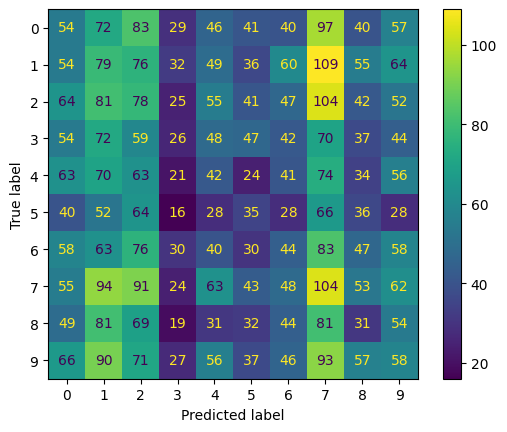

In [57]:
y_pred = tf.argmax(y_pred_one_hot, axis = 1)
print(y_pred.shape)

y_true = []
for X, y in val_ds:
    for b in y:
        y_true.append(tf.argmax(b))
y_true = np.asarray(y_true)
print(y_true.shape)

ConfusionMatrixDisplay.from_predictions(y_true, y_pred)


In [61]:
print(history.history)

{'loss': [0.7998979091644287, 0.5918168425559998, 0.43080055713653564, 0.36013850569725037, 0.3275411128997803, 0.3102884292602539, 0.30002492666244507, 0.29273131489753723, 0.2868969738483429, 0.2822892665863037, 0.2787538766860962, 0.27695339918136597, 0.27283790707588196, 0.27032962441444397, 0.2691006064414978, 0.2664194405078888, 0.26392537355422974, 0.26279476284980774, 0.26110637187957764, 0.2590673863887787, 0.25741031765937805, 0.25603771209716797, 0.25502651929855347, 0.2522645890712738, 0.25164124369621277, 0.2508483827114105, 0.24923497438430786, 0.24771110713481903, 0.24700307846069336, 0.24494020640850067, 0.24459601938724518, 0.24348236620426178, 0.2415226399898529, 0.24077875912189484, 0.24037602543830872, 0.23934292793273926, 0.2379426211118698, 0.2367674857378006, 0.23554493486881256, 0.2349337637424469], 'binary_crossentropy': [0.7998979091644287, 0.5918168425559998, 0.43080055713653564, 0.36013850569725037, 0.3275411128997803, 0.3102884292602539, 0.30002492666244507